### Introduction to Machine Learning in Finance and Insurance (Spring 2024)
# Project 2: Insurance Claim Prediction

### Team members: LastName1 FirstName1, LastName2 FirstName2, LastName3 FirstName3

In [6]:
### Import all the Python libraries you are going to use
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
### Fix random seed for reproducibility
np.random.seed(10)

# Exercise 1. Poisson GLM.

In [14]:
# Read csv file
# You can use pandas (see the notebook "Project 2 - Insurance Claim Prediction - Sandbox")
mtpl_freq_df = pd.read_csv('freMTPL2freq.csv',
                           sep=';',
                           decimal=',')

In [15]:
mtpl_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   VehPower    678007 non-null  int64  
 1   VehAge      678007 non-null  int64  
 2   DrivAge     678007 non-null  int64  
 3   BonusMalus  678007 non-null  int64  
 4   VehBrand    678007 non-null  object 
 5   VehGas      678007 non-null  object 
 6   Density     678007 non-null  int64  
 7   Region      678007 non-null  object 
 8   Exposure    678007 non-null  float64
 9   ClaimNb     678007 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 51.7+ MB


In [21]:
# Check that exposure is always positive
all(mtpl_freq_df.Exposure > 0)

True

In [23]:
# Add frequency to the data
mtpl_freq_df['Freq'] = mtpl_freq_df.ClaimNb / mtpl_freq_df.Exposure
mtpl_freq_df.describe()

,VehPower,VehAge,DrivAge,BonusMalus,Density,Exposure,ClaimNb,Freq
count,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000
mean,6.454653,7.044218,45.499061,59.761588,1792.430975,0.528547,0.038913,0.117907
std,2.050902,5.666235,14.137492,15.636700,3958.663031,0.364081,0.204752,2.002881
min,4.000000,0.000000,18.000000,50.000000,1.000000,0.002732,0.000000,0.000000
25%,5.000000,2.000000,34.000000,50.000000,92.000000,0.180000,0.000000,0.000000
50%,6.000000,6.000000,44.000000,50.000000,393.000000,0.490000,0.000000,0.000000
75%,7.000000,11.000000,55.000000,64.000000,1658.000000,0.990000,0.000000,0.000000
max,15.000000,100.000000,100.000000,230.000000,27000.000000,1.000000,5.000000,365.000000


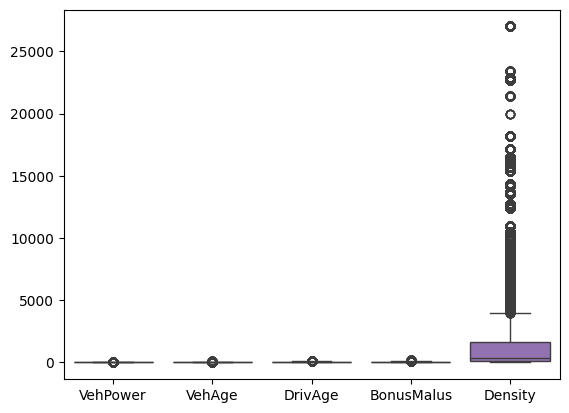

In [57]:
mtpl_features, mtpl_response = mtpl_freq_df.columns[:-3], mtpl_freq_df.columns[-3:]
fig, ax = 
plt.tight_layout()
plt.show()

In [46]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6], name="yaxis data"))
fig.add_trace(go.Scatter(x=[2, 3, 4], y=[40, 50, 60], name="yaxis2 data", yaxis="y2"))
fig.add_trace(go.Scatter(x=[4, 5, 6], y=[1000, 2000, 3000], name="yaxis3 data", yaxis="y3"))

# Customize axes and titles
fig.update_layout(
    xaxis=dict(domain=[0.25, 0.75]),
    yaxis=dict(title="yaxis title"),
    yaxis2=dict(title="yaxis2 title", overlaying="y", side="right"),
    yaxis3=dict(title="yaxis3 title", anchor="free", overlaying="y", autoshift=True),
    title_text="Shifting y-axes with autoshift"
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Pre-process features


In [ ]:
# Train-test split


In [3]:
# Train Poisson GLM
# You can use sklearn.linear_model.Poisson_Regressor (see the notebook "Project 2 - Insurance Claim Prediction - Sandbox")


In [ ]:
# Print MAE, MSE and loss on train and test data sets


# Exercise 2. Poisson feedforward neural network.

In [ ]:
# Implement and train a neural network model
# You can use Keras (see the notebook "Project 2 - Insurance Claim Prediction - Sandbox")


In [1]:
# Print MAE, MSE and loss on train and test data sets
